# <center>Observation data flood of Senamhi</center>
---

link: [ANDREA](https://snirh.ana.gob.pe/ANDREA/Login.aspx)

In [1]:
!pip install -q leafmap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import glob
import numpy as np
import warnings #el gdf se complica, porque yo no!
import leafmap.foliumap as leafmap
from IPython.display import HTML
import shapely

warnings.filterwarnings("ignore")

In [3]:
# HTML('<iframe src="https://snirh.ana.gob.pe/ANDREA/Integrado.aspx" width="1100" height="750"></iframe>')

In [4]:
######################################################### FUNCTIONS #####################################################

def InfoStations(list_stations):
    
    df_stations = pd.DataFrame()

    for station in list_stations:
        
        df_station = pd.read_excel(station, skiprows = 3, index_col = 0, header = 1)
        
        df_station = df_station.iloc[:7, 0:2]
        
        df_station.drop(columns = ["Unnamed: 1"], inplace = True)
        
        df_stations = pd.concat([df_stations, df_station], axis = 1)

    df_stations = df_stations.transpose()
    
    df_stations.index = df_stations.index.str[1:]
    
    coordinates = pd.DataFrame()

    coordinates[['latitud', 'longitud', 'altitud']] = df_stations["WGS 84 Geográficas"].str.split('/', expand = True)

    df_stations.drop("WGS 84 Geográficas", axis = 1, inplace = True)

    df_stations["Latitud"] = coordinates["latitud"].str.lstrip("Latitud: ").astype(float)

    df_stations["Longitud"] = coordinates["longitud"].str.lstrip("Longitud: ").astype(float)

    df_stations["Altitud"] = coordinates["altitud"].str.lstrip("Altitud(msnm): ").astype(float)
            
    df_stations["geometry"] = df_stations.apply(lambda punto: shapely.geometry.Point(punto['Longitud'], punto['Latitud']), axis = 1)
    
    df_stations.drop(columns = ["Longitud", "Latitud"], inplace = True)
    
    gdf = gpd.GeoDataFrame(df_stations, geometry = "geometry", crs = "EPSG:4326")

    return gdf


def StationsBasin(df):
    
    df = df.copy()
    
    basin = df["Unidad Hidrográfica"].unique()[0][1:]
    
    return basin


def Station_df(list_):
    
    df_station = pd.read_excel(list_, skiprows = 12, index_col = 0, header = 1, skipfooter = 2)
    
    df_index = pd.read_excel(list_, skiprows = 4, usecols = "C")
    
    station_name = df_index.columns.to_list()[0][1:]
    
    df_station = df_station.copy()
    
    variable = df_index[:1].values[0][0][1:]
    
    if variable == 'Caudal Promedio Diario (m³/s)':
    
        df_station.drop(columns = ["Día"], inplace = True)
        
    elif variable == 'Precipitación Acumulada 1 Mes (mm)':
        
        pass
    
    i1 = 31
    
    data = []; day = []; month = []; year = []
    
    sum_year = - 1
        
    for _ in range(int(len(df_station)/31)): 
                
        data_year = df_station.iloc[i1 - 31:i1]
                
        i1 += 31
        
        sum_year += 1
        
        for n in range(len(data_year.columns)):
            
            data.extend(data_year.iloc[:,n].to_list())
            
            day.extend(list(range(1, 32)))
            
            month.extend([n + 1]*31)
            
            year.extend([df_station.index[0] + sum_year]*31)
    
    df = pd.DataFrame({station_name: data, "day": day, "month": month, "year": year})
    
    df['fecha'] = pd.to_datetime(df[['year', 'month', 'day']], errors = 'coerce', format = '%Y-%m-%d')
    
    df = df.dropna(subset = ['fecha'])

    df.drop(columns = ["year", "month", "day"], inplace = True)
    
    df.set_index("fecha", inplace = True)
            
    df = df.loc[df.first_valid_index():df.last_valid_index()]
    
    return df

In [5]:
path_flood = '/kaggle/input/canete-basin/station_flood/'

path_pp = '/kaggle/input/canete-basin/station_precipitation/'

data_shps = glob.glob("*.shp", dir_fd = "/kaggle/input/data-shp-peru/99_total")

list_flood = glob.glob('*.xlsx', dir_fd = path_flood)

list_pp = glob.glob('*.xlsx', dir_fd = path_pp)

list_flood = [path_flood + i for i in list_flood]

list_pp = [path_pp + i for i in list_pp]

list_flood

['/kaggle/input/canete-basin/station_flood/DatosSerie (2).xlsx',
 '/kaggle/input/canete-basin/station_flood/DatosSerie (3).xlsx',
 '/kaggle/input/canete-basin/station_flood/DatosSerie (5).xlsx',
 '/kaggle/input/canete-basin/station_flood/DatosSerie (4).xlsx']

In [6]:
list_pp

['/kaggle/input/canete-basin/station_precipitation/DatosSerie (10).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (14).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (13).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (2).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (11).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (3).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (5).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (6).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (15).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (9).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (7).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (12).xlsx',
 '/kaggle/input/canete-basin/station_precipitation/DatosSerie (4).xlsx',
 '/kaggle/input/canete-basin/station_precipit

In [7]:
stations_info_flood = InfoStations(list_flood)

stations_info_flood

Estación,Variable,Operador,Tipo,Ámbito Político,Ámbito Administrativo,Unidad Hidrográfica,Altitud,geometry
Socsi,Caudal Promedio Diario (m³/s),Junta De Usuarios Del Sub Distrito De Riego C...,Convencional / Hidrométrica,Dpto: Lima / Prov: Cañete / Dist.: Lunahuana,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,312.0,POINT (-76.19453 -13.02816)
Capillucas,Caudal Promedio Diario (m³/s),Compañia Electrica El Platanal S.A.,Automática / Hidrométrica,Dpto: Lima / Prov: Yauyos / Dist.: Allauca,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,0.0,POINT (-75.94450 -12.74500)
Toma Imperial,Caudal Promedio Diario (m³/s),Servicio Nacional Meteorología E Hidrología,Convencional / Hidrométrica,Dpto: Lima / Prov: Cañete / Dist.: Lunahuana,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,400.0,POINT (-76.21667 -13.00000)
Putinza,Caudal Promedio Diario (m³/s),Compañia Electrica El Platanal S.A.,Automática / Hidrométrica,Dpto: Lima / Prov: Yauyos / Dist.: Allauca,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,1640.0,POINT (-75.95975 -12.66816)


In [8]:
stations_info_pp = InfoStations(list_pp)

stations_info_pp

Estación,Variable,Operador,Tipo,Ámbito Político,Ámbito Administrativo,Unidad Hidrográfica,Altitud,geometry
Socsi Cañete,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Cañete / Dist.: Lunahuana,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,500.0,POINT (-76.19453 -13.02833)
Yauricocha,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Yauyos / Dist.: Alis,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,4675.0,POINT (-75.72264 -12.31647)
Vilca,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Yauyos / Dist.: Huancaya,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,3864.0,POINT (-75.82619 -12.11461)
Carania,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Yauyos / Dist.: Carania,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,3875.0,POINT (-75.87214 -12.34439)
Tanta,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Yauyos / Dist.: Tanta,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,4323.0,POINT (-76.01667 -12.11667)
Catahuasi,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Yauyos / Dist.: Catahuasi,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,1179.0,POINT (-75.88333 -12.80000)
Huangascar,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Yauyos / Dist.: Huangascar,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,2533.0,POINT (-75.83367 -12.89856)
Huantan,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Yauyos / Dist.: Huantan,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,3272.0,POINT (-75.81667 -12.45000)
Yauyos,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Yauyos / Dist.: Colonia,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,2327.0,POINT (-75.90844 -12.49178)
Picamaran,Precipitación Acumulada 1 Día (mm),Servicio Nacional Meteorología E Hidrología,Convencional / Climática,Dpto: Lima / Prov: Yauyos / Dist.: Allauca,AAA: Cañete Fortaleza / ALA: Mala Omas Cañete,Cuenca Cañete,1950.0,POINT (-76.05000 -12.76667)


In [9]:
basin = StationsBasin(stations_info_flood)

basin

'Cuenca Cañete'

In [10]:
uh_peru = gpd.read_file("/kaggle/input/data-shp-peru/99_total/UnidadesHidrograficas.shp", crs = "EPSG:4326")

rio = gpd.read_file("/kaggle/input/data-shp-peru/99_total/Rios_quebradas_ANA_geogpsperu_SuyoPomalia.shp", crs = "EPSG:4326")

network_hydric = rio[rio["NOMBRE_UH"] == basin]

gdf_basin = uh_peru[uh_peru["NOMBRE"] == basin]

In [11]:
Map = leafmap.Map()

Map.add_basemap("HYBRID")

Map.add_gdf(stations_info_flood, style = {}, layer_name = "flood")

Map.add_gdf(stations_info_pp, style = {}, layer_name = "precipitation")

Map.add_gdf(gdf_basin, style = {"color": "red", "fillOpacity": 0}, layer_name = "basin")

Map.add_gdf(network_hydric, style = {"color": "blue"}, layer_name = "layer 2")

Map

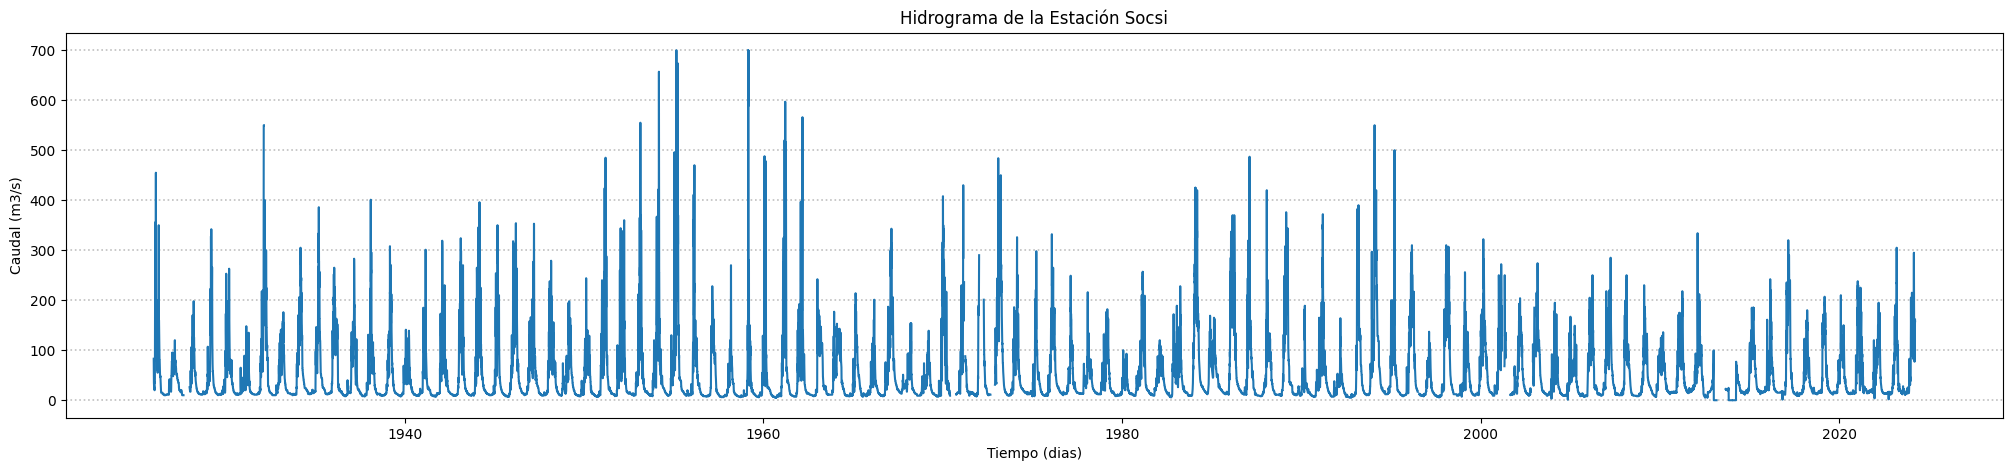

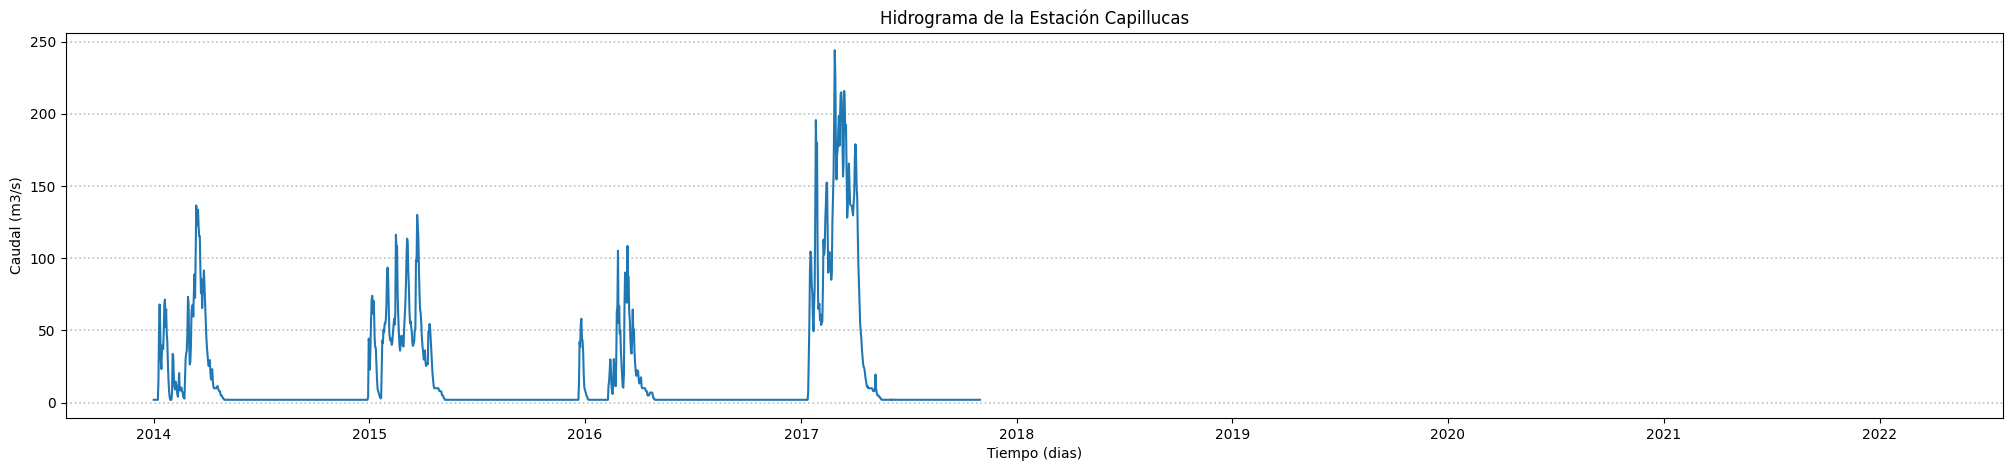

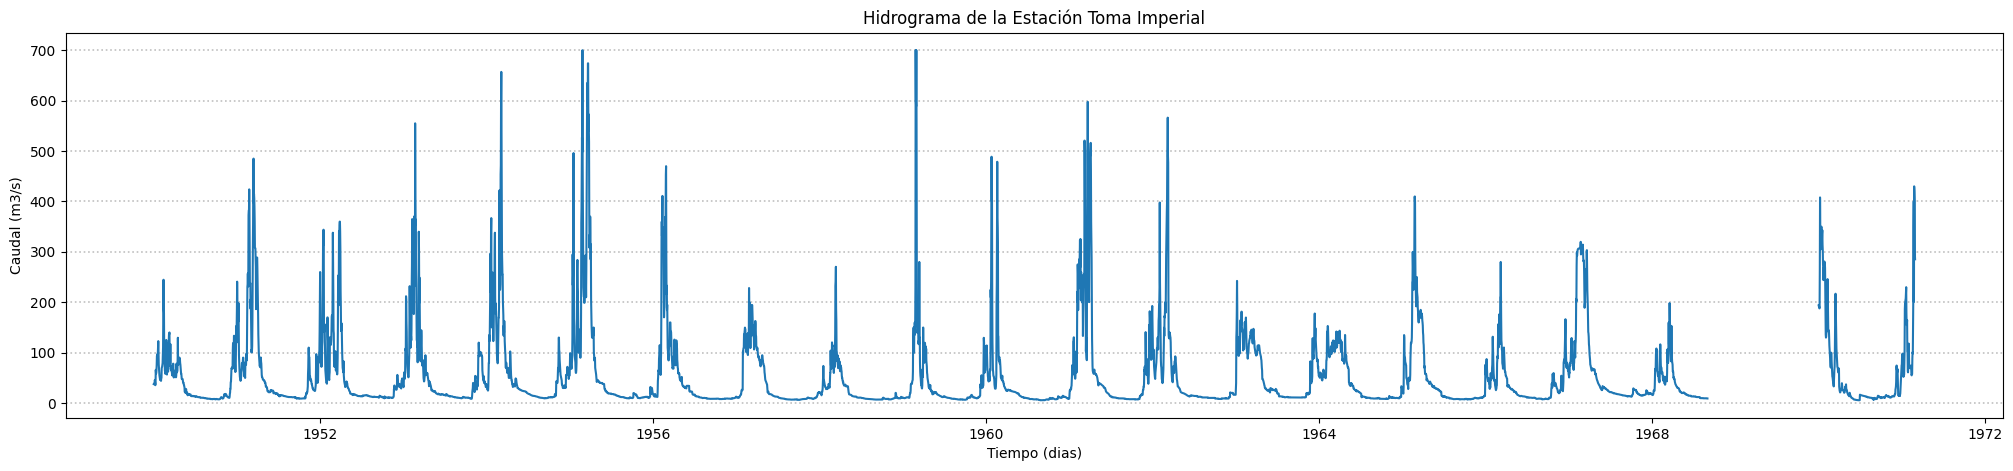

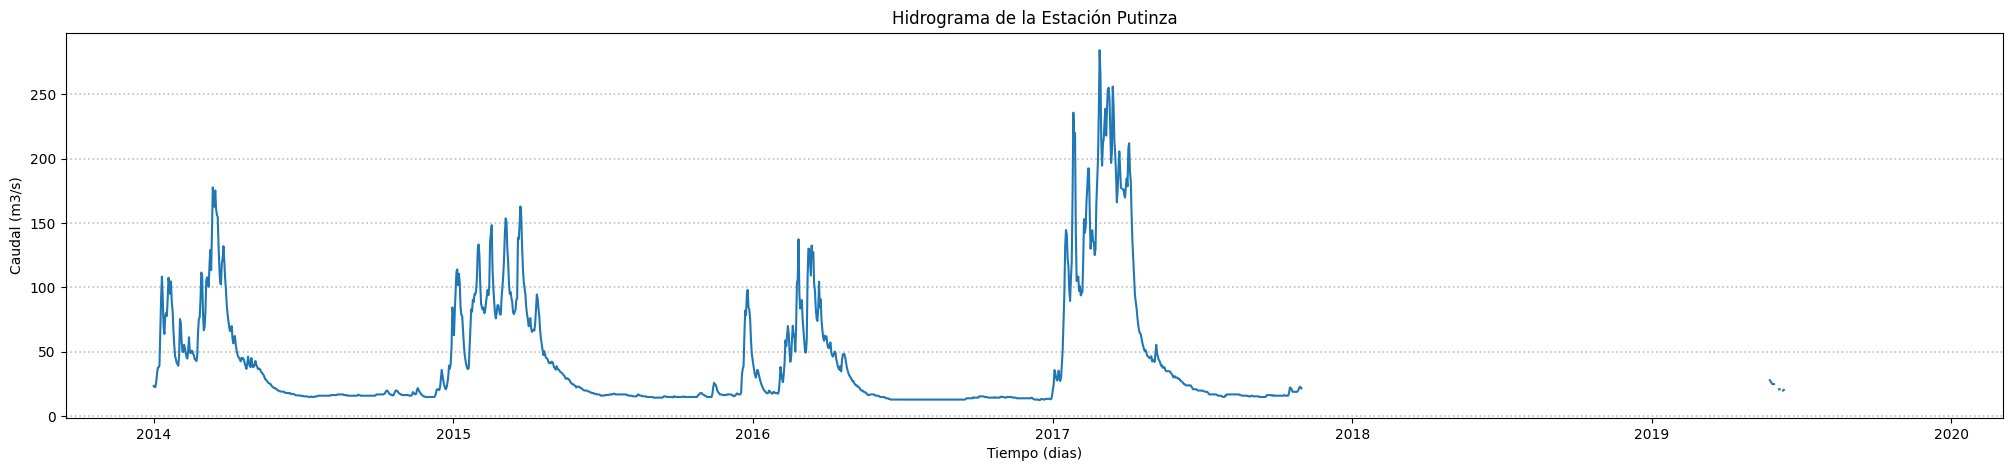

In [12]:
for i in range(len(list_flood)):
    plt.figure(figsize = (25, 5))
    plt.plot(Station_df(list_flood[i]))
    plt.title(f"Hidrograma de la Estación {stations_info_flood.index[i]}")
    plt.xlabel("Tiempo (dias)")
    plt.ylabel("Caudal (m3/s)")
    plt.grid(c = "silver", ls = ":", axis = "y", lw = 1.2)
    plt.show()

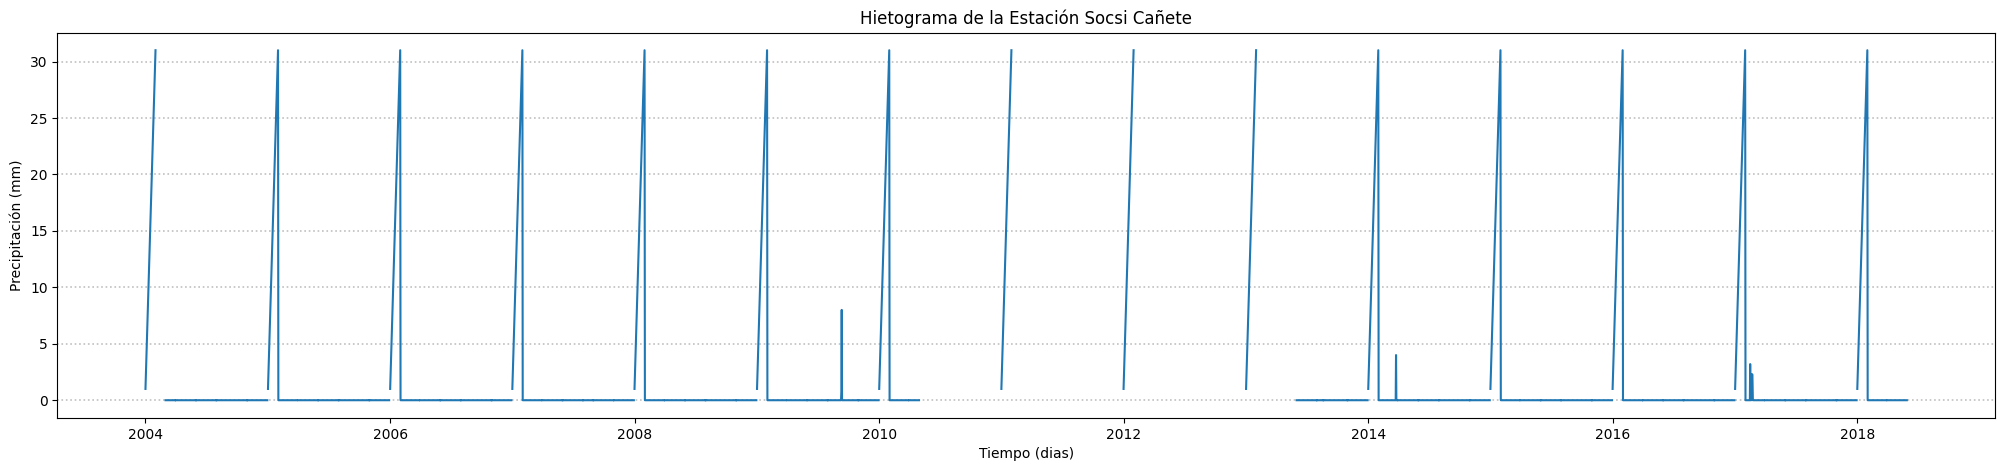

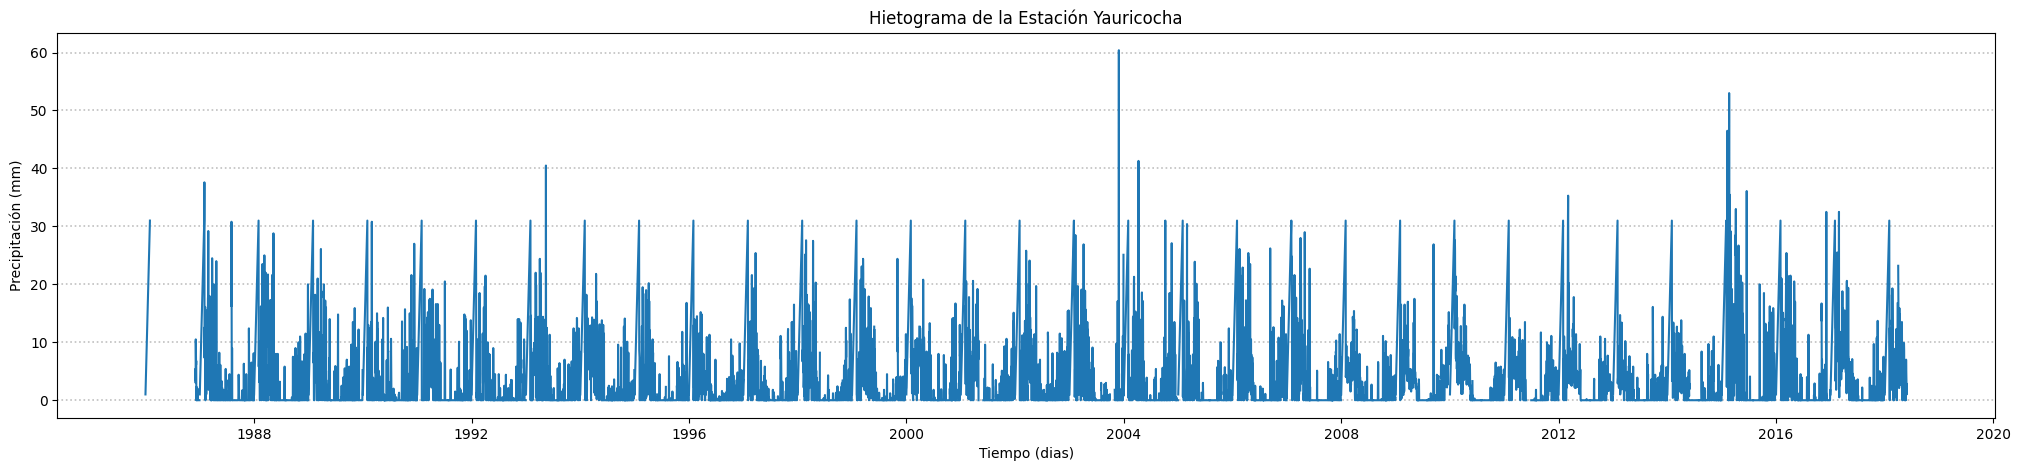

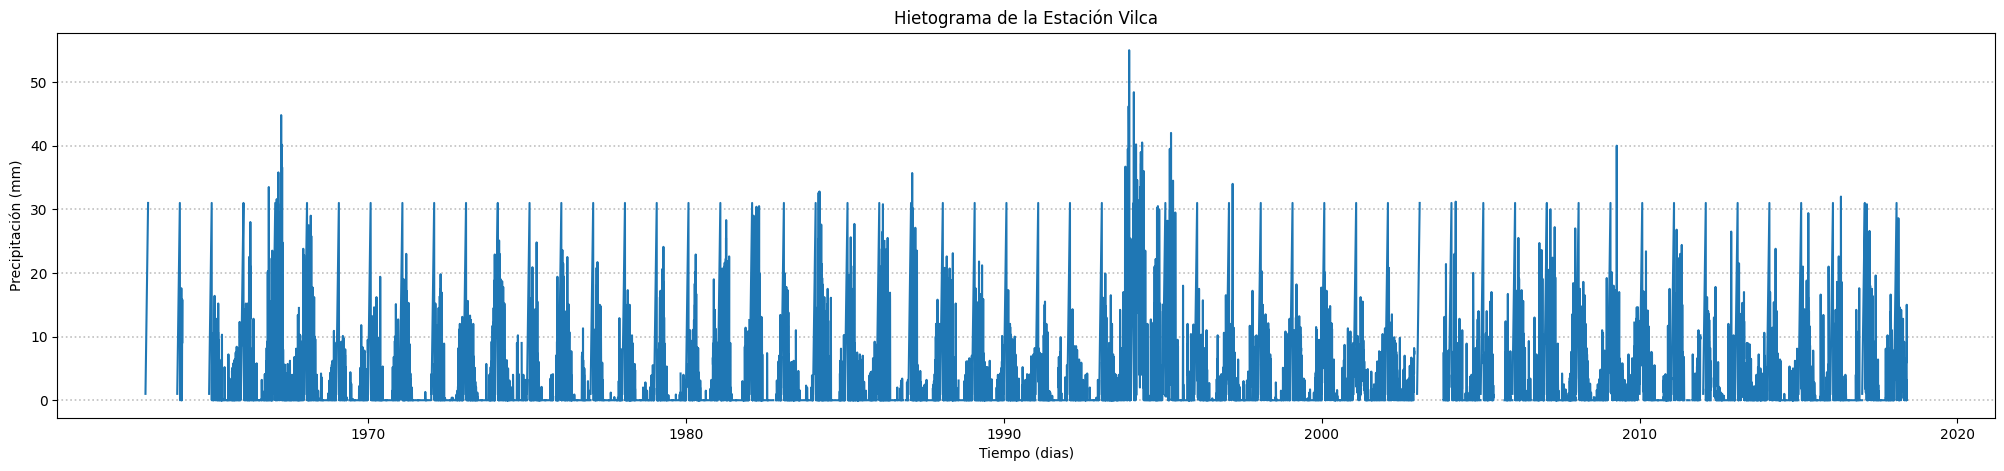

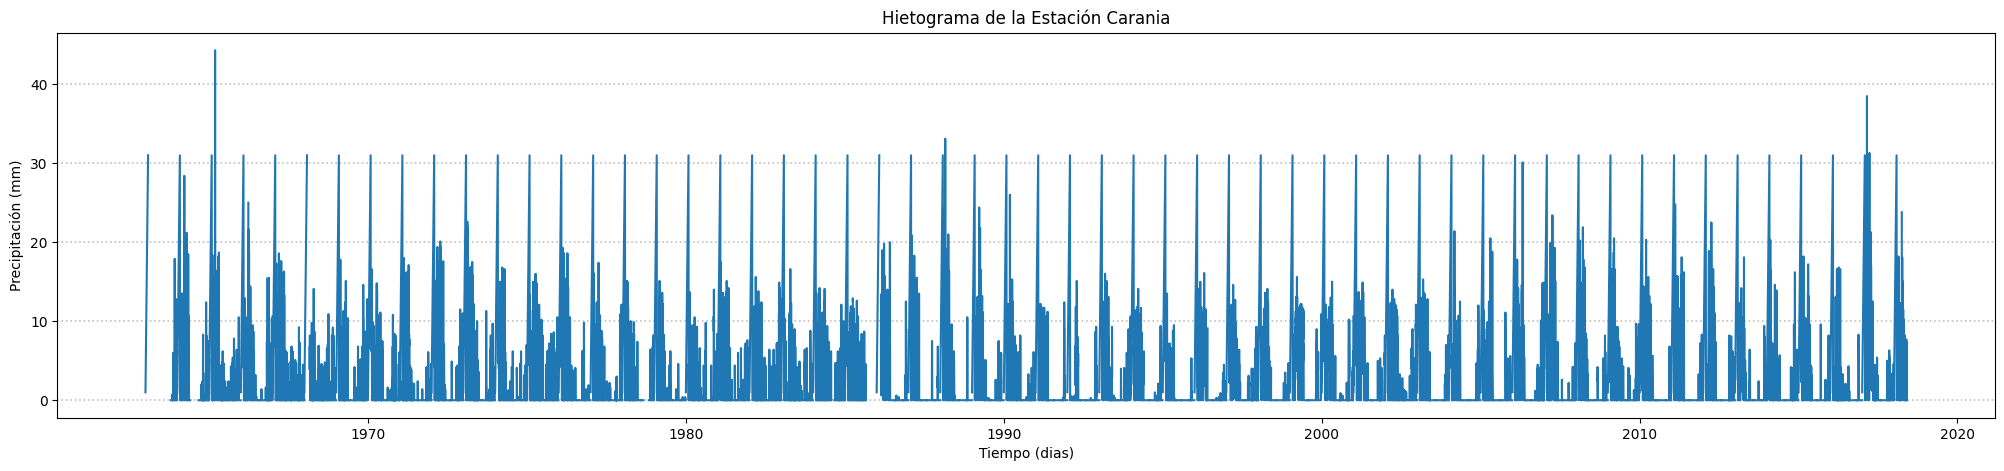

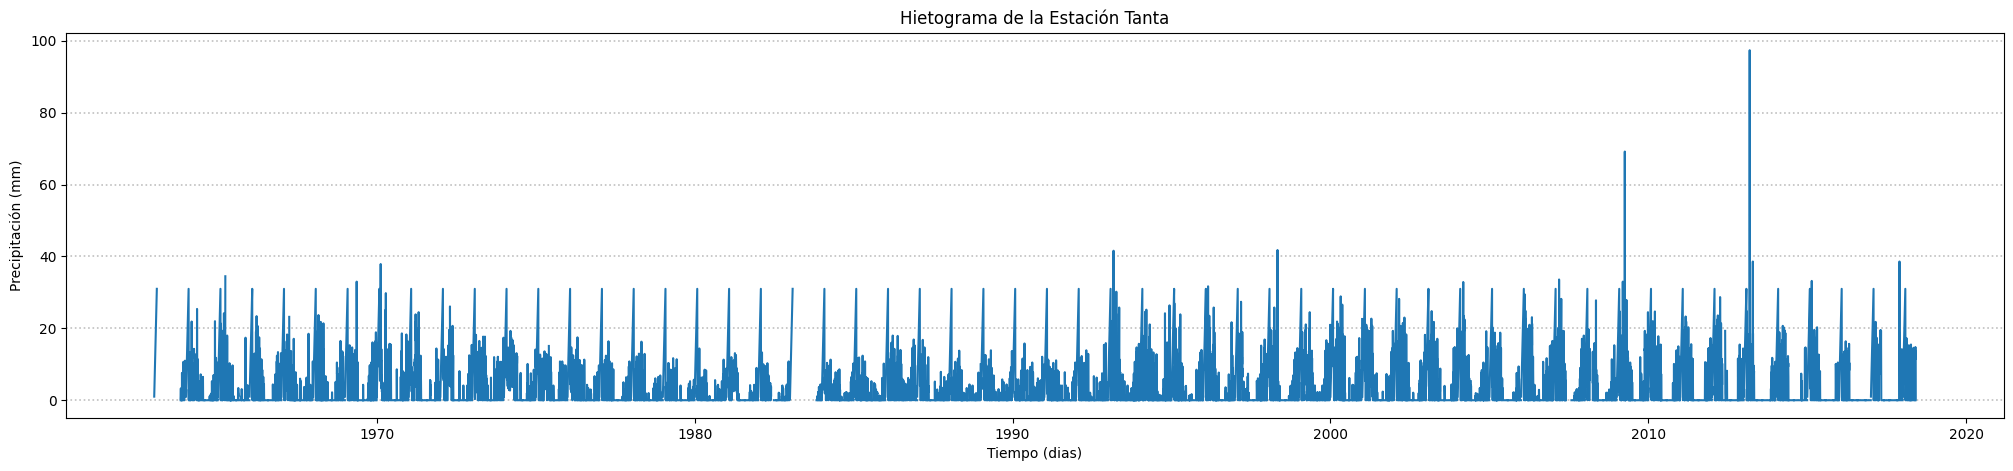

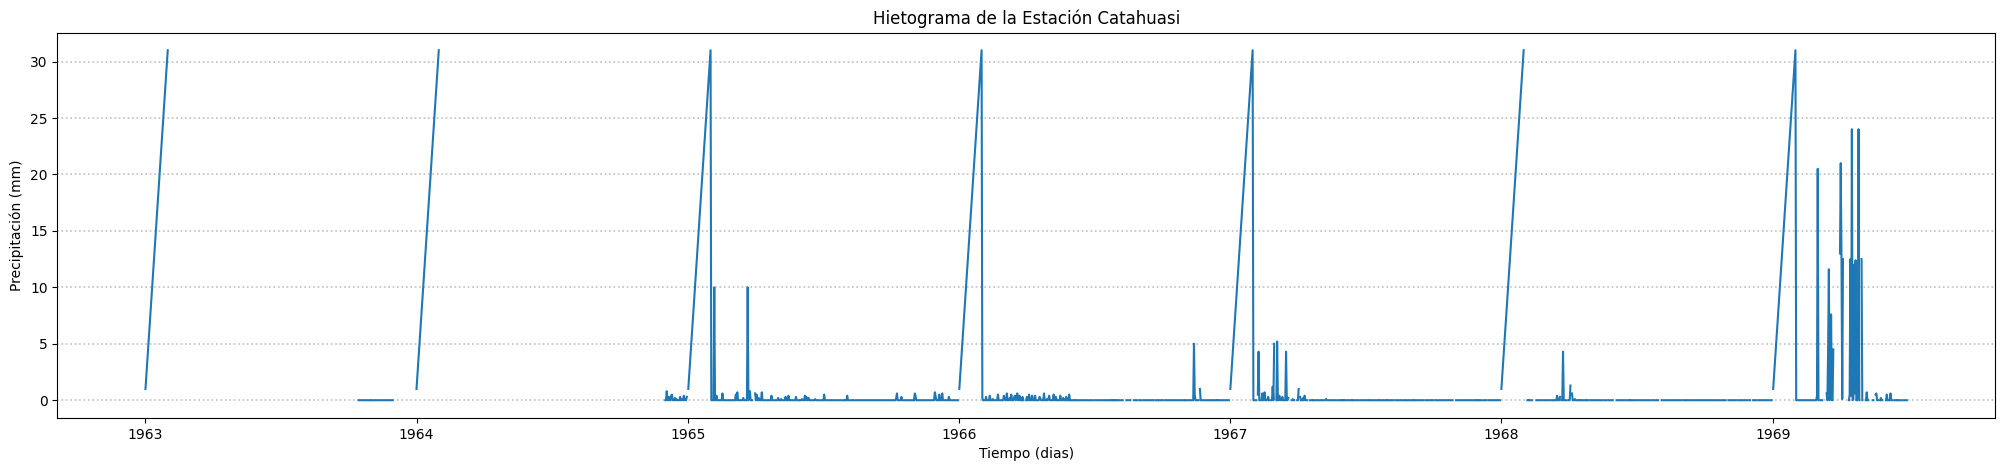

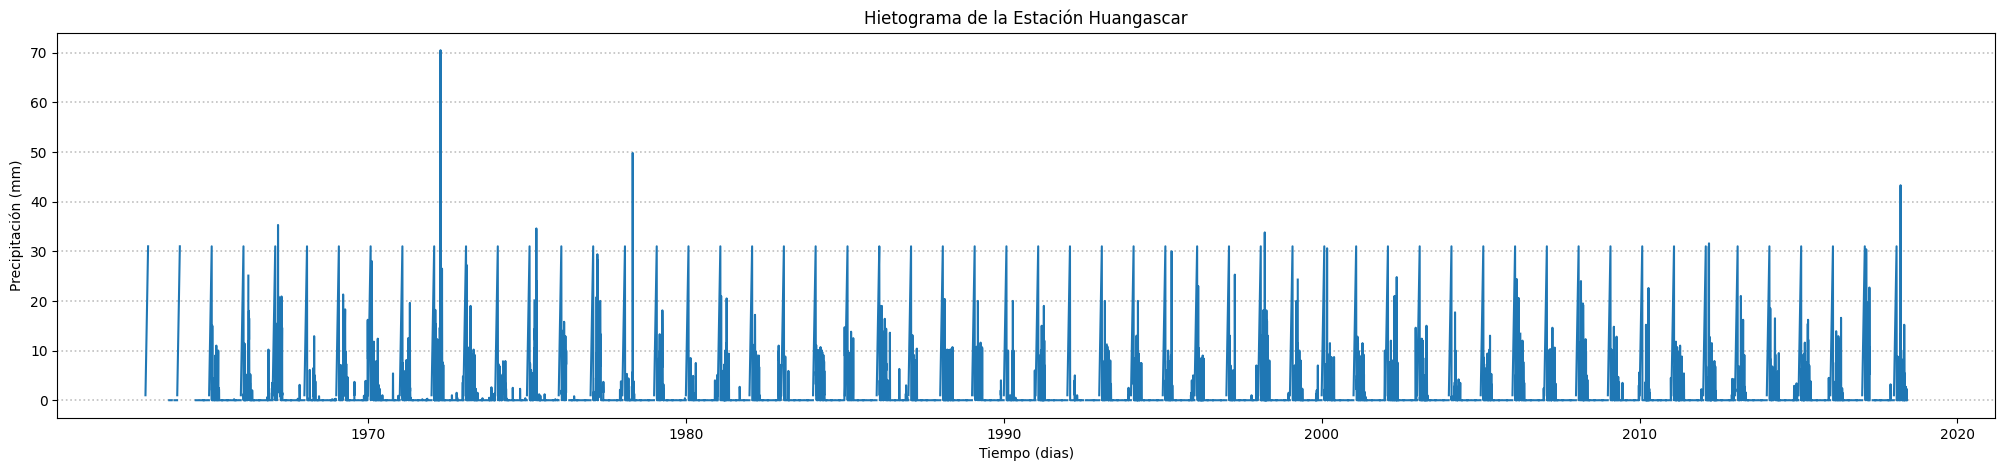

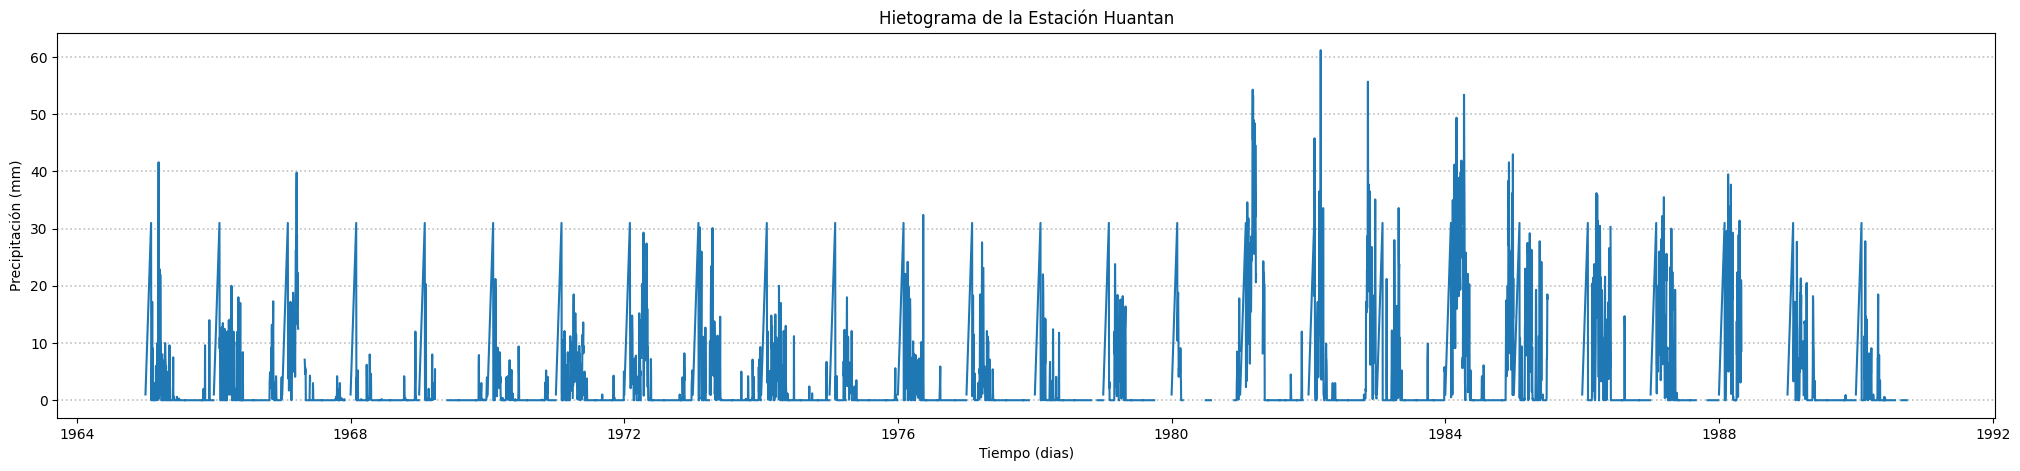

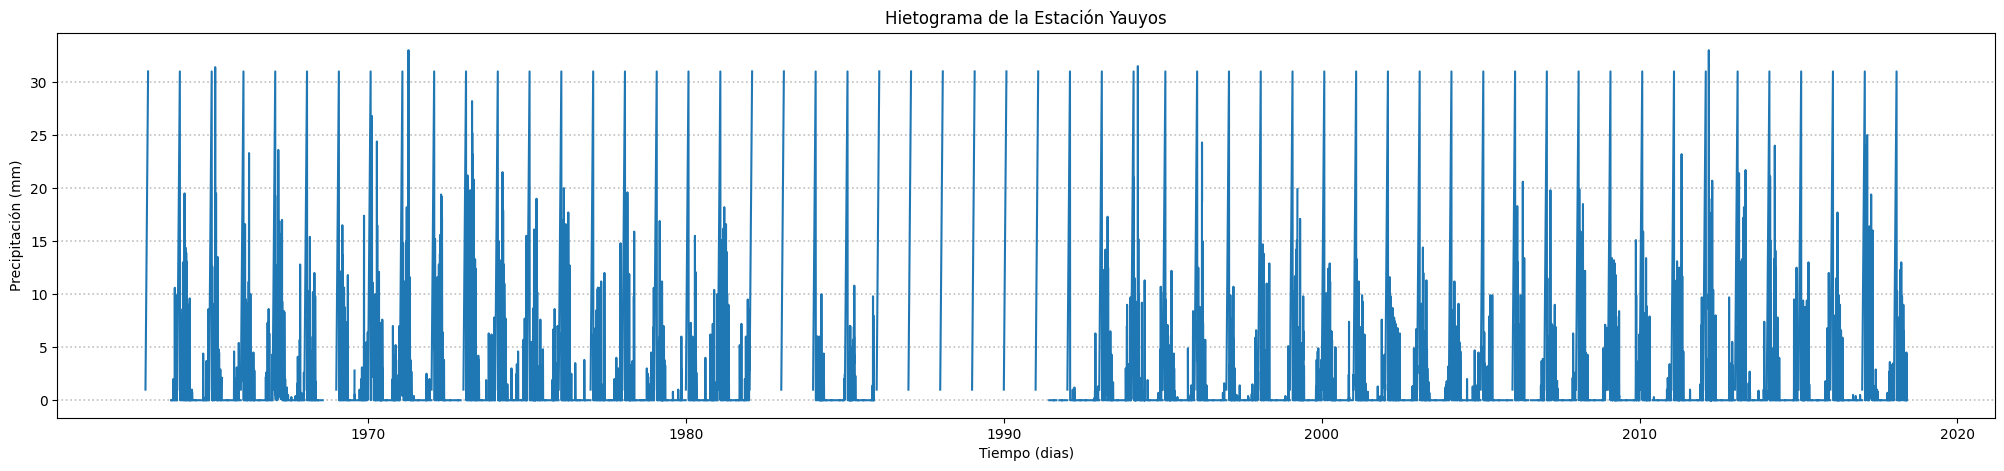

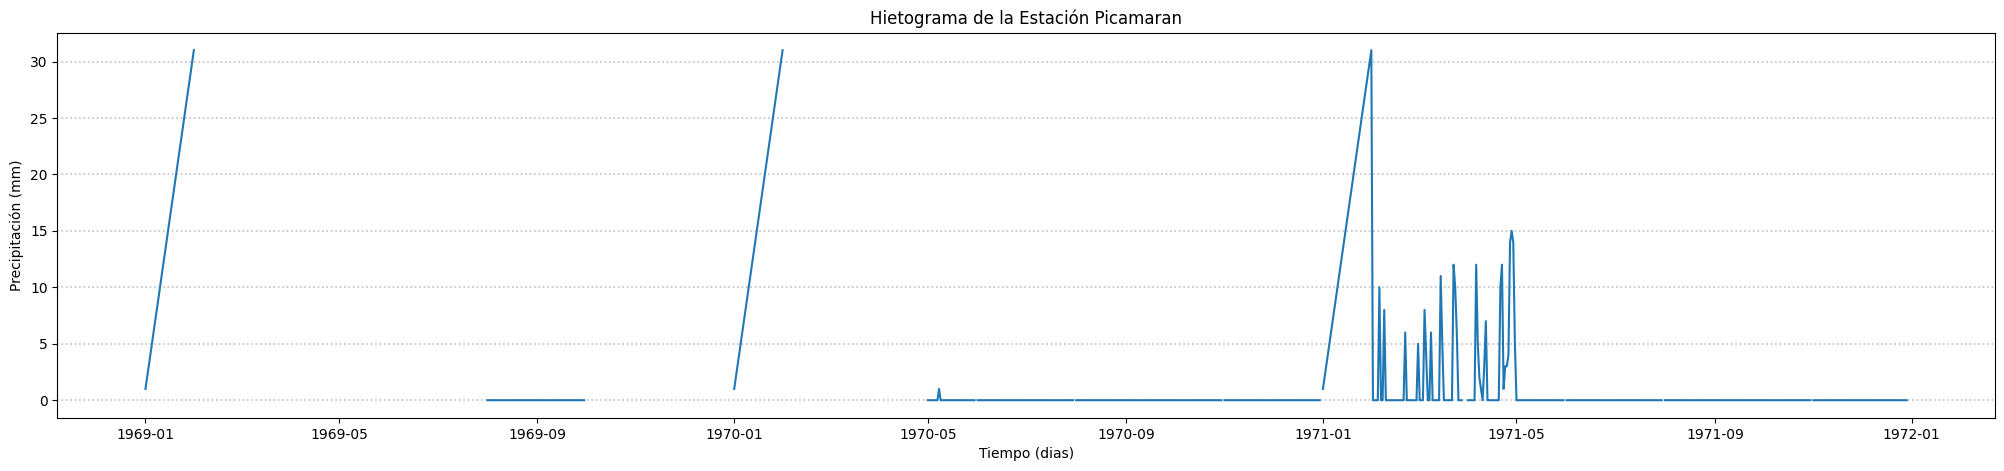

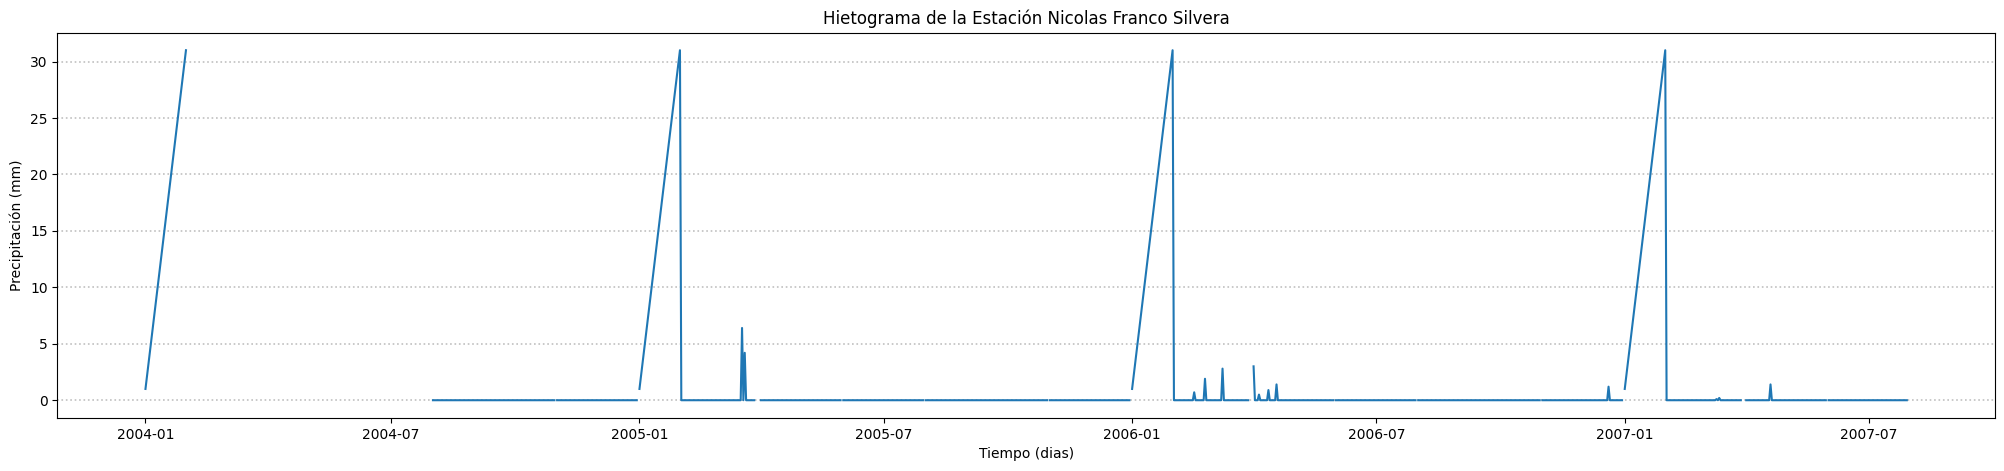

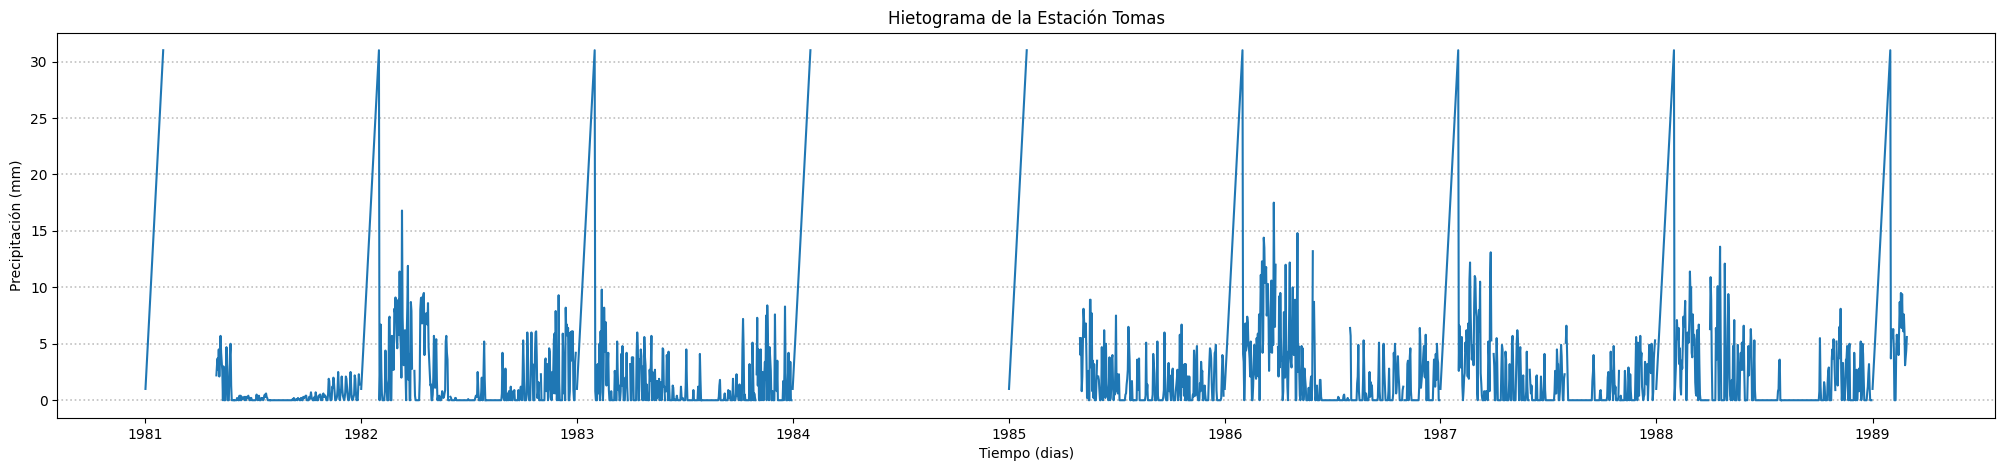

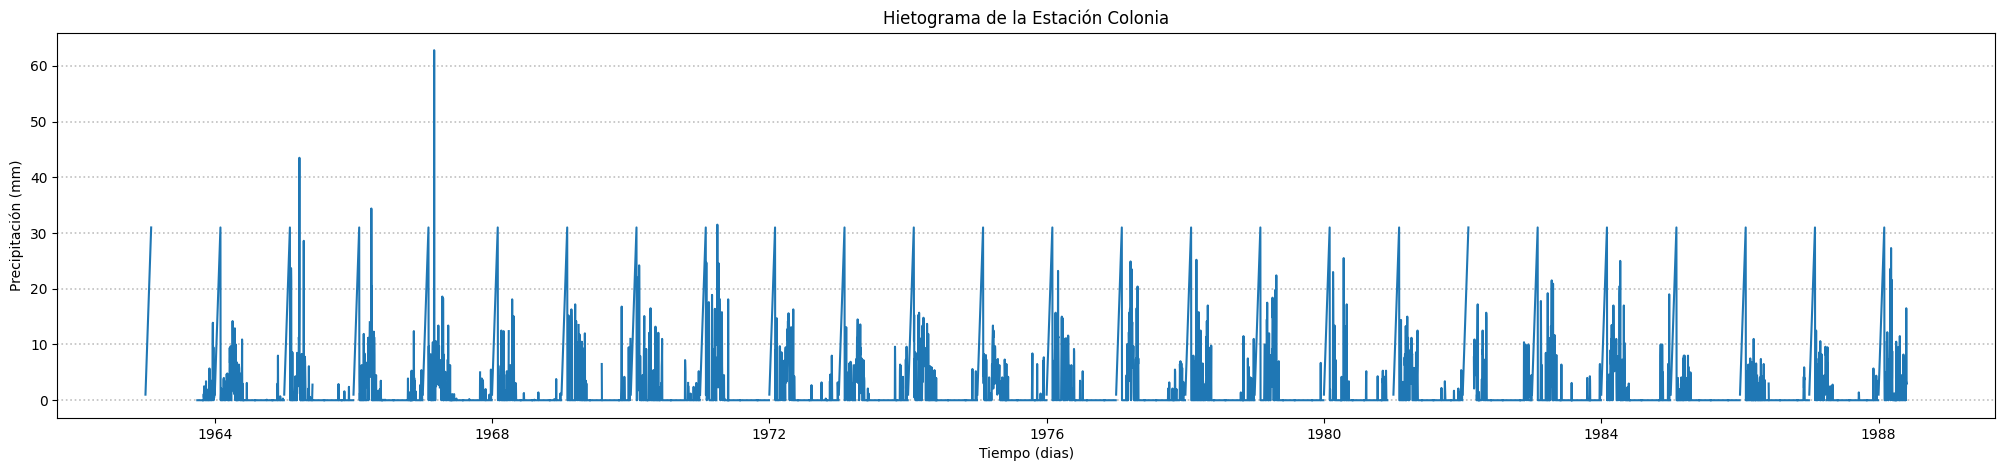

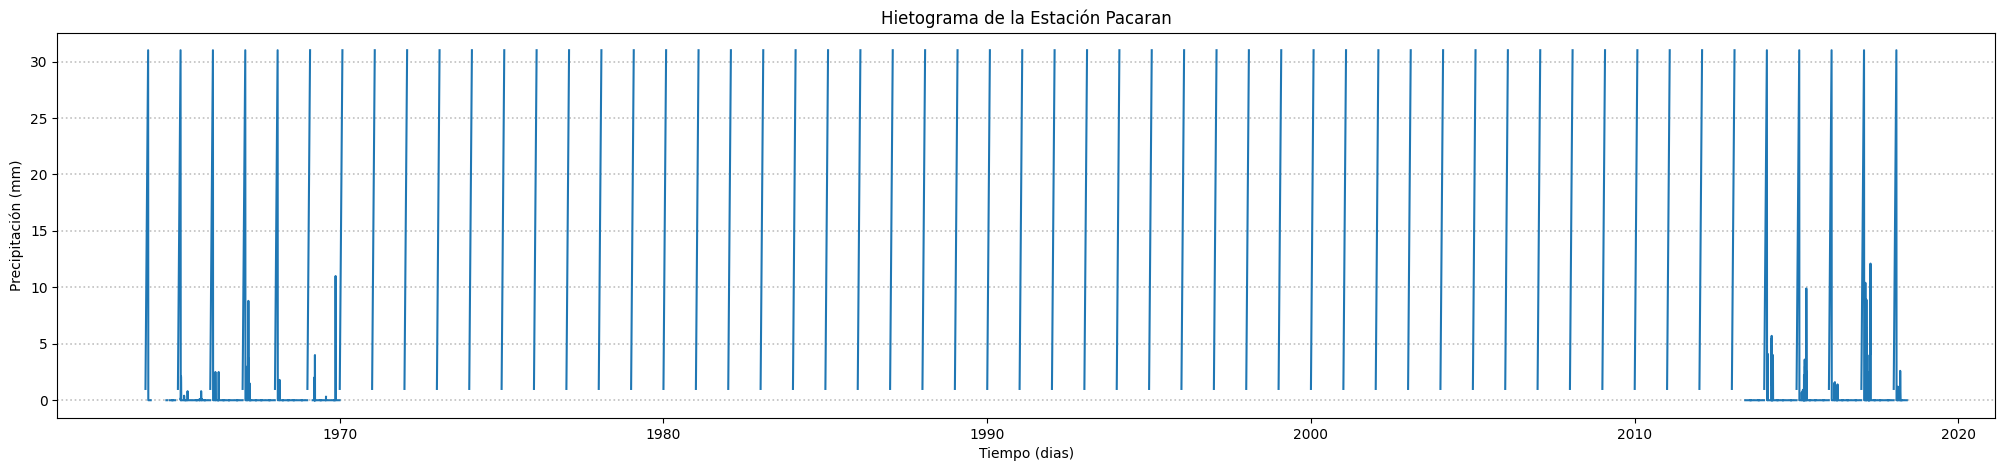

In [13]:
for i in range(len(list_pp)):
    plt.figure(figsize = (25, 5))
    plt.plot(Station_df(list_pp[i]))
    plt.title(f"Hietograma de la Estación {stations_info_pp.index[i]}")
    plt.xlabel("Tiempo (dias)")
    plt.ylabel("Precipitación (mm)")
    plt.grid(c = "silver", ls = ":", axis = "y", lw = 1.2)
    plt.show()

# Completación de datos faltantes

Cantidad de datos faltantes para cada estación

In [14]:
nan_values = pd.DataFrame({
    "D. Totales": [len(Station_df(list_flood[i])) for i in range(len(stations_info_flood))],
    "D. Faltantes": [Station_df(list_flood[i]).isna().sum()[0] for i in range(len(stations_info_flood))],
})

nan_values["D. Completos"] = nan_values["D. Totales"] - nan_values["D. Faltantes"]

nan_values.index = stations_info_flood.index.to_list()

nan_values["% Completos"] = round((nan_values["D. Completos"]/nan_values["D. Totales"])*100, 2)

nan_values["Fecha Inicio"] = [Station_df(list_flood[i]).index.min() for i in range(len(stations_info_flood))]

nan_values["Fecha Fin"] = [Station_df(list_flood[i]).index.max() for i in range(len(stations_info_flood))]

nan_values

,D. Totales,D. Faltantes,D. Completos,% Completos,Fecha Inicio,Fecha Fin
Socsi,35880,1011,34869,97.18,1926-01-01,2024-03-26
Capillucas,2983,1580,1403,47.03,2014-01-01,2022-03-02
Toma Imperial,7729,487,7242,93.70,1950-01-01,1971-02-28
Putinza,2148,734,1414,65.83,2014-01-01,2019-11-18


In [15]:
nan_values = pd.DataFrame({
    "D. Totales": [len(Station_df(list_pp[i])) for i in range(len(stations_info_pp))],
    "D. Faltantes": [Station_df(list_pp[i]).isna().sum()[0] for i in range(len(stations_info_pp))],
})

nan_values["D. Completos"] = nan_values["D. Totales"] - nan_values["D. Faltantes"]

nan_values.index = stations_info_pp.index.to_list()

nan_values["% Completos"] = round((nan_values["D. Completos"]/nan_values["D. Totales"])*100, 2)

nan_values["Fecha Inicio"] = [Station_df(list_pp[i]).index.min() for i in range(len(stations_info_pp))]

nan_values["Fecha Fin"] = [Station_df(list_pp[i]).index.max() for i in range(len(stations_info_pp))]

nan_values

,D. Totales,D. Faltantes,D. Completos,% Completos,Fecha Inicio,Fecha Fin
Socsi Cañete,5263,1147,4116,78.21,2004-01-01,2018-05-29
Yauricocha,11837,611,11226,94.84,1986-01-01,2018-05-29
Vilca,20238,1700,18538,91.60,1963-01-01,2018-05-29
Carania,20238,997,19241,95.07,1963-01-01,2018-05-29
Tanta,20238,1037,19201,94.88,1963-01-01,2018-05-29
Catahuasi,2373,765,1608,67.76,1963-01-01,1969-06-30
Huangascar,20238,915,19323,95.48,1963-01-01,2018-05-29
Huantan,9404,1278,8126,86.41,1965-01-01,1990-09-30
Yauyos,20238,3402,16836,83.19,1963-01-01,2018-05-29
Picamaran,1093,372,721,65.97,1969-01-01,1971-12-29


In [17]:
nan_values2 = nan_values[nan_values["% Completos"] > 90]
nan_values2

,D. Totales,D. Faltantes,D. Completos,% Completos,Fecha Inicio,Fecha Fin
Yauricocha,11837,611,11226,94.84,1986-01-01,2018-05-29
Vilca,20238,1700,18538,91.60,1963-01-01,2018-05-29
Carania,20238,997,19241,95.07,1963-01-01,2018-05-29
Tanta,20238,1037,19201,94.88,1963-01-01,2018-05-29
Huangascar,20238,915,19323,95.48,1963-01-01,2018-05-29
Colonia,9281,468,8813,94.96,1963-01-01,1988-05-29


In [22]:
nan_values2.index.tolist()

['Yauricocha', 'Vilca', 'Carania', 'Tanta', 'Huangascar', 'Colonia']